***
### Guía 3 - Ejercicio 2
Determine la deformación y los esfuerzos principales en función de la posición para una chapa con un agujero en el centro sujeta a tracción por sus extremos, como se muestra en la figura. Las dimensiones de la chapa son de 20 x 10 pulgadas y su espesor de una pulgada. El radio del agujero central es también de 1 pulgada. Tome E = 30 x 10^6 psi y v = 0.30.
Analice el problema con número creciente de elementos y estudie su convergencia.
***

#### Comienzo del programa
Se importan las librerías de las funciones a utilizar durante el programa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
np.set_printoptions(precision=4, linewidth=150)

#### Definición de constantes y datos del problema
Debajo se definen los valores y datos a utilizar para el desarrollo del problema. Donde se tiene:

Por la forma en que se está aplicando la fuerza, asumo simetría, por lo que con calcular un cuarto de la placa, es suficiente. Dado esto, se asume que el rectángulo es de 10x5

Definición de constantes y datos del problema.

In [2]:
# Dada simetría, tomo la mitad de las dos dimensiones mayores
length = 10     # en pulgadas
heigth = 5      # en pulgadas
thickness = 1   # en pulgadas
young = 30E6    # En psi
poisson = 0.3   # Es adimensional.
stress = 1000   # en psi
radius = 1      # en pulgada
lc = 1          # Factor de refinamiento del mallado
lcr = 1/10      # Factor para mayor refinamiento en el agujero. Es necesario que este valor sea más fino para obtener mayor detalle de lo que sucede.

#### Inicializo el gmsh

In [3]:
gmsh.initialize()
gmsh.model.add('G3E2')

Definición de los puntos de la sección a estudiar

In [4]:
# Sección rectangular
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc)
p2 = gmsh.model.geo.addPoint(0, heigth, 0, lc)
p3 = gmsh.model.geo.addPoint(length, heigth, 0, lc)
p4 = gmsh.model.geo.addPoint(length, 0, 0, lc)

# Sección semicircular
p5 = gmsh.model.geo.addPoint(radius, 0, 0, lcr)
p6 = gmsh.model.geo.addPoint(0, radius, 0, lcr)

Definición de las líneas y curvas de trabajo 

In [5]:
# Sección rectangular
l1 = gmsh.model.geo.addLine(p6, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p5)
rectangle = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

In [6]:
# Sección semicircular
l5 = gmsh.model.geo.addCircleArc(p5, p1, p6)
circleArc = gmsh.model.geo.addCurveLoop([l5])

In [7]:
# Unión de las líneas, generación de la curva y superficie de trabajo
curve = gmsh.model.geo.addCurveLoop([l1, l3, l4, l2, l5])
surface = gmsh.model.geo.addPlaneSurface([curve])

In [8]:
# Se hace una sincronización con gmsh
gmsh.model.geo.synchronize()

Definición de los grupos físicos
Donde, según el número del primer argumento es el tipo de elemento, es decir, si el primer argumento es:
- 0: Es un punto
- 1: Es una línea
- 2: Es una superficie

Lo que se define a continuación es:
* trashNode: Es el nodo que utilicé como centro del semiarco del agujero.
* stressedCorners: Son las esquinas que se encuentran en la zona de tracción
* xPinned: Es la línea que se encuentra empotrada en x, esto se debe basicamente a la simetría del problema, donde esta línea no posee movimiento en x.
* yPinned: Es la línea que se encuentra empotrada en y, esto se debe basicamente a la simetría del problema, donde esta línea no posee movimiento en y.
* stressedLine: Es la línea donde se le aplican las cargas.
* totalSurface: Es la superficie total que queda de trabajo.

In [9]:
# Puntos
trashNode = gmsh.model.addPhysicalGroup(0, [p1])
gmsh.model.setPhysicalName(0, trashNode, 'trash')

stressedCorners = gmsh.model.addPhysicalGroup(0, [p3, p4])
gmsh.model.setPhysicalName(0, stressedCorners, 'Corners')


# Líneas
xPinned = gmsh.model.addPhysicalGroup(1, [l1])
gmsh.model.setPhysicalName(1, xPinned, 'xPinned')

yPinned = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1, yPinned, 'yPinned')

stressedLine = gmsh.model.addPhysicalGroup(1, [l3])
gmsh.model.setPhysicalName(1, stressedLine, 'stressedLine')


# Superficie
totalSurface = gmsh.model.addPhysicalGroup(2, [surface])
gmsh.model.setPhysicalName(2, totalSurface, 'totalSurface')

In [10]:
# Se hace una sincronización con gmsh
gmsh.model.geo.synchronize()

Se genera el mallado con gmsh

In [11]:
gmsh.model.mesh.generate(2)
gmsh.model.geo.synchronize()

***
#### Recolección de datos

Obtengo información de los physical group

In [12]:
# Puntos
trashNodes = gmsh.model.mesh.get_nodes_for_physical_group(0, trashNode)[0].astype(int) - 1

# Líneas
xPinnedNodes = gmsh.model.mesh.get_nodes_for_physical_group(1, xPinned)[0].astype(int) - 1
yPinnedNodes = gmsh.model.mesh.get_nodes_for_physical_group(1, yPinned)[0].astype(int) - 1

# Superficies
triangleNodes = gmsh.model.mesh.get_nodes_for_physical_group(2, totalSurface)[0].astype(int) - 1

##### Nodos
Se tiene:
* nodeInfo: Va a tener un array correspondiente a los índices o etiquetas de cada nodo y luego otro array, con las posiciones en (x,y,z) de cada uno de los nodos, de manera seguida, por lo que se tiene que generar una matriz de nodos que tenga esta información ordenada.
* nodeNumber: Al preguntar el tamaño del primer array de nodeInfo, se puede saber facilmente cuántos nodos se tiene.

In [13]:
nodeInfo = gmsh.model.mesh.get_nodes()
nodeNumber = nodeInfo[0].shape[0]
nodeMatrix = nodeInfo[1].reshape(nodeNumber, 3)

##### Elementos
Se "pide" a gmsh que dé información de los elementos según el tipo 2, de manera de tener información de los triangulos que forman el mallado.
Dado que la numeración del gmsh arranca en 1, mientras que la de python arranca en cero, resto un 1 a todos los valores obtenidos.

In [14]:
elementTags, elements = gmsh.model.mesh.get_elements_by_type(2)
conectivityMatrix = elements.reshape([elementTags.shape[0], 3]).astype(int) - 1
elementsNumber = conectivityMatrix.shape[0]

Genero las entidades se asociacian a physical groups

In [15]:
stressedEntity = gmsh.model.getEntitiesForPhysicalGroup(1, stressedLine)
t1, t2, stressedLength = gmsh.model.mesh.getElements(1, stressedEntity[0])
stressedLength = np.ravel(stressedLength).astype(int) - 1
stressedLength = stressedLength.reshape(int(len(stressedLength)/2), 2)

***
### Cálculos
#### Cálculo de las fuerzas

In [16]:
forces = np.zeros((2*nodeNumber, 1))

In [17]:
for i, line in enumerate(stressedLength):
    node1 = int(line[0])
    node2 = int(line[1])
    localLength = np.abs(nodeMatrix[node1, 1] - nodeMatrix[node2, 1])
    localForce = (stress * localLength * thickness)/2 * np.array([[1], [1]])
    index = np.array([2 * node1, 2 * node2])
    forces[index] += localForce

Teniendo las fuerzas, se pueden separar en las distintas componentes.

In [18]:
xForces = forces[::2]
yForces = forces[1::2]

##### Grafico con matlabplot

(-1.0, 13.0)

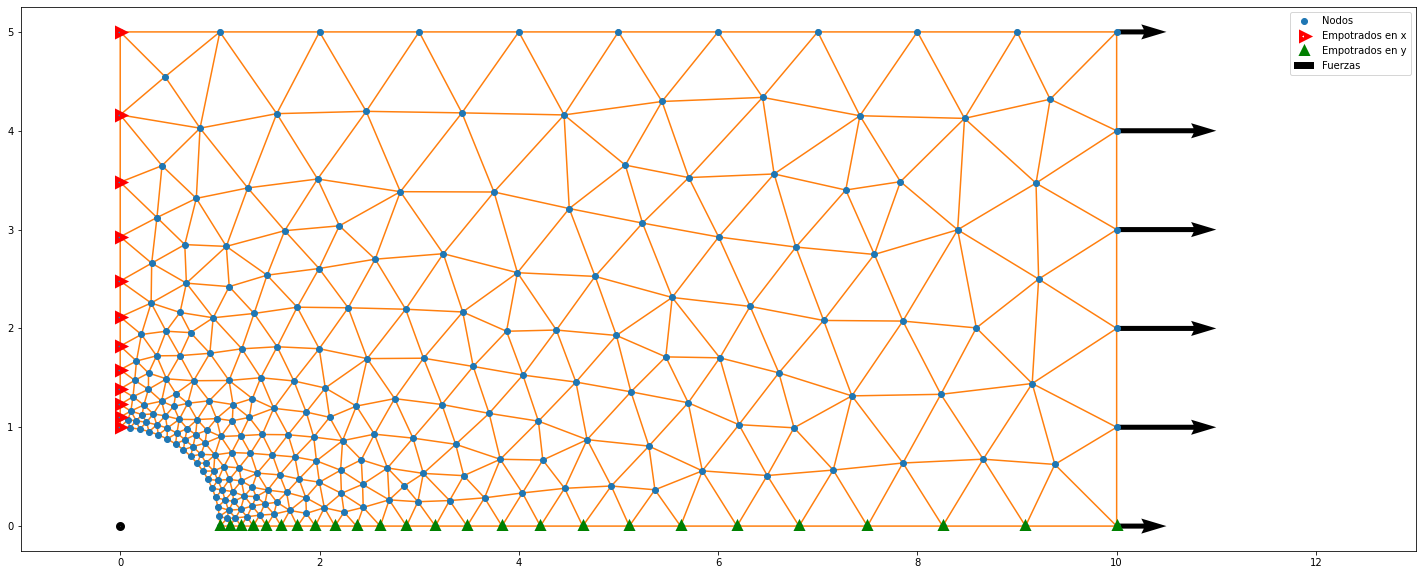

In [19]:
plt.rc('figure', figsize=(25,10))
plt.plot(nodeMatrix[triangleNodes, 0], nodeMatrix[triangleNodes, 1], 'o', label='Nodos')
plt.triplot(nodeMatrix[triangleNodes, 0], nodeMatrix[triangleNodes, 1], conectivityMatrix-conectivityMatrix.min())
plt.quiver(nodeMatrix[1:, 0], nodeMatrix[1:, 1], xForces[1:], yForces[1:], scale=1000,units='x', label='Fuerzas')

plt.plot(nodeMatrix[xPinnedNodes, 0], nodeMatrix[xPinnedNodes, 1], '>', label='Empotrados en x',  markerfacecolor='none', markeredgecolor='r', markeredgewidth=5)
plt.plot(nodeMatrix[yPinnedNodes, 0], nodeMatrix[yPinnedNodes, 1], '^', label='Empotrados en y', markersize=4, markerfacecolor='none', markeredgecolor='g', markeredgewidth=5)
plt.plot(nodeMatrix[trashNodes, 0], nodeMatrix[trashNodes, 1], 'o', markersize=4, markerfacecolor='none', markeredgecolor='k', markeredgewidth=5)
plt.legend()
plt.xlim([-1, length + 3])

Genero los vectores s y r

In [20]:
s = []
r = []
for i in range(nodeNumber):
    if i in xPinnedNodes:
        s.append(2*i)
    if i in yPinnedNodes:
        s.append(2*i + 1)
    if i in trashNodes:
        s.append(2*i)
        s.append(2*i + 1)

s = np.ravel(s)
r = np.delete(np.arange(2*nodeNumber), s)

##### Cálculo de la matriz de rigidez

In [21]:
globalStiffMatrix = np.zeros([2*nodeNumber, 2*nodeNumber])
localStiffMatrix = np.zeros([6, 6])
totalB = []
D = (young/(1 - poisson ** 2))*np.array([
                                        [1, poisson, 0],
                                        [poisson, 1, 0],
                                        [0, 0, (0.5 * (1 - poisson))]
                                        ])

In [22]:
for i in range(elementsNumber):
    elementCoordinates = []
    B = np.zeros([3, 6])
    alpha = np.zeros(3)
    beta = np.zeros(3)
    gamma = np.zeros(3)

    element = conectivityMatrix[i, :]
    xNodes = nodeMatrix[element, 0]
    yNodes = nodeMatrix[element, 1]

    # Cálculo del área del elemento
    aux = np.ones_like(xNodes.reshape(-1, 1))
    elementCoordinates = np.hstack([aux, xNodes.reshape(-1, 1), yNodes.reshape(-1, 1)])
    area = abs(np.linalg.det(elementCoordinates) / 2)

    # Coeficientes alfa, beta y gamma
    alpha[0] = xNodes[1]*yNodes[2] - xNodes[2]*yNodes[1]
    alpha[1] = xNodes[0]*yNodes[2] - xNodes[2]*yNodes[0]
    alpha[2] = xNodes[0]*yNodes[1] - xNodes[1]*yNodes[0]

    beta[0] = yNodes[1] - yNodes[2]
    beta[1] = yNodes[2] - yNodes[0]
    beta[2] = yNodes[0] - yNodes[1]

    gamma[0] = xNodes[2] - xNodes[1]
    gamma[1] = xNodes[0] - xNodes[2]
    gamma[2] = xNodes[1] - xNodes[0]

    # Cálculo matriz B
    for j in range(3):
        B[0, 2*j] = beta[j]
        B[1, 2*j + 1] = gamma[j]
        B[2, 2*j] = beta[j]
        B[2, 2*j + 1] = gamma[j]

    B = (1 / (2*area)) * B

    totalB.append(B)

    # Cálculo de la matriz de rigidez
    localStiffMatrix = thickness * area * np.dot(B.transpose(), np.dot(D, B))
    index = []
    for j in range(3):
        index.append(np.linspace(2 * element[j], 2 * element[j] + 1, 2))

    index = np.ravel(index).astype(int)

    globalStiffMatrix[np.ix_(index, index)] += localStiffMatrix

> Estoy teniendo problemas al calcular la matriz global. No sé si lo estoy haciendo bien.

##### Calculo de desplazamientos y fuerzas

In [23]:
displacements = np.zeros((2*nodeNumber, 1))
displacements[r] = np.linalg.solve(globalStiffMatrix[np.ix_(r, r)], forces[r])
forces[s] = globalStiffMatrix[s, :].dot(displacements)

In [24]:
xDisplacements = displacements[::2]
yDisplacements = displacements[1::2]
xTotalForces = forces[::2]
yTotalForces = forces[1::2]

##### Gráfico de los desplazamientos y fuerzas con matplot

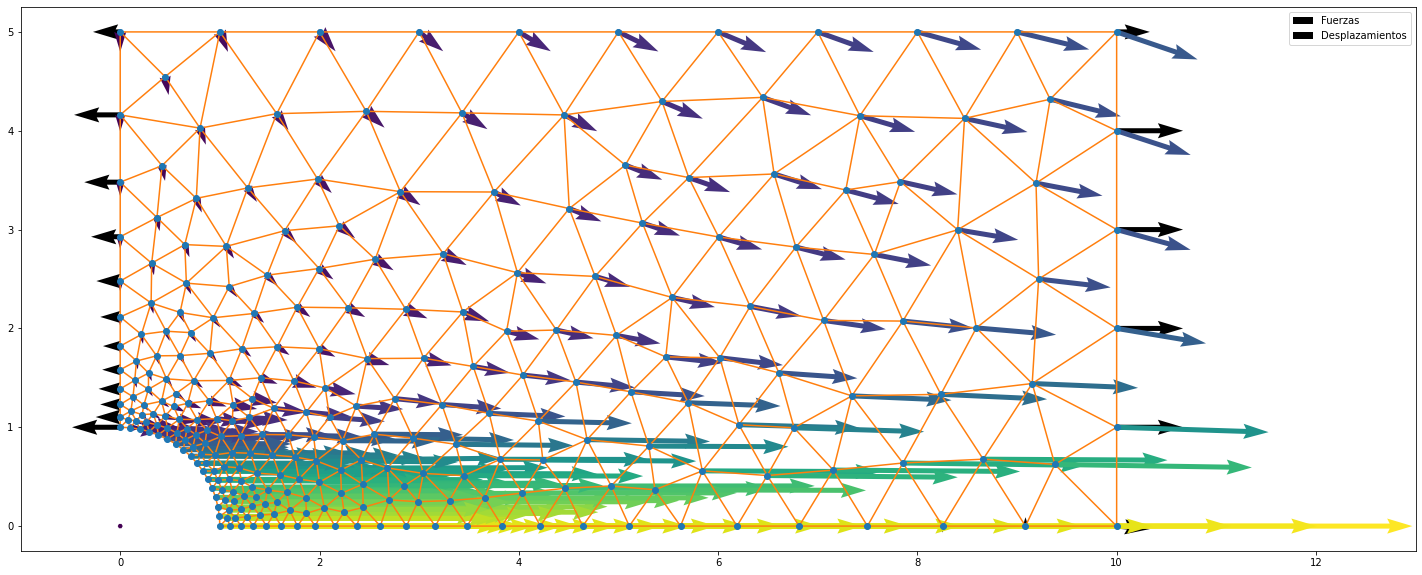

In [25]:
plt.plot(nodeMatrix[triangleNodes, 0], nodeMatrix[triangleNodes, 1], 'o')
plt.triplot(nodeMatrix[triangleNodes, 0], nodeMatrix[triangleNodes, 1], conectivityMatrix-conectivityMatrix.min())
plt.quiver(nodeMatrix[1:, 0], nodeMatrix[1:, 1], xTotalForces[1:], yTotalForces[1:], scale=1500, units='x', label='Fuerzas')
plt.quiver(nodeMatrix[:, 0], nodeMatrix[:, 1], xDisplacements, yDisplacements, xDisplacements, scale=0.005, label='Desplazamientos')
plt.xlim([-1, length + 3])
plt.legend()

#### Cálculo de tensiones en cada punto

In [26]:
tension = []
for i in range(elementsNumber):
    element = conectivityMatrix[i, :]
    indexA = []

    for j in range(3):
        indexA.append(np.linspace(2 * element[j], 2 * element[j] + 1, 2))

    indexA = np.ravel(index).astype(int)

    tension.append(np.dot(D, np.dot(totalB[i], displacements[indexA])))
tension = np.array(tension)

##### Gráfico de tensiones con matplot

In [27]:
tensionMax = (tension[:, 0] + tension[:, 1]) / 2 + np.sqrt(((tension[:, 0] + tension[:, 1]) ** 2) / 4 + tension[:, 2]**2)

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cmap = ax.tripcolor(nodeMatrix[triangleNodes, 0], nodeMatrix[triangleNodes, 1], conectivityMatrix-conectivityMatrix.min(), facecolors=tensionMax, edgecolor='k', linewidth=0.05)
cbar = plt.colorbar(cmap)
ax.set_xlim([-1, length + 1])

(-1.0, 11.0)

ValueError: Collections can only map rank 1 arrays

<Figure size 1080x360 with 2 Axes>

#### Gráfico de tensiones con gmsh

Convierto a matriz los desplazamientos y matrices, sacando los nodos que hayan quedado fuera

In [29]:
displacementMatrix = np.zeros((nodeNumber, 3))
forcesMatrix = np.zeros((nodeNumber, 3))

for i in range(nodeNumber):
    if i not in trashNodes:
        displacementMatrix[i, 0] = displacements[2 * i]
        displacementMatrix[i, 1] = displacements[2 * i + 1]
        forcesMatrix[i, 0] = forces[2 * i]
        forcesMatrix[i, 1] = forces[2 * i + 1]

In [30]:
gmshDisplacements = gmsh.view.add("Desplazamientos")
gmshForces = gmsh.view.add("Fuerzas")
gmshTension = gmsh.view.add("Tensión")

viewDisplacements = gmsh.view.addModelData(gmshDisplacements, 0, 'G3E2', 'NodeData', nodeInfo[0], displacementMatrix, numComponents = 3)
viewForces = gmsh.view.addModelData(gmshForces, 0, 'G3E2', 'NodeData', nodeInfo[0], forcesMatrix, numComponents = 3)
viewTension = gmsh.view.addModelData(gmshTension, 0,  'G3E2', 'ElementData', elementTags, tension[:, 0].reshape(-1, 1), numComponents = 1)

In [ ]:
gmsh.fltk.run()
gmsh.finalize()